# Intrinsic periodicity of the SIR system
Continuing our investigation of the Susceptible-Infected-Recovered system, 

$$
\dot{S} = -\frac{\beta*S*I}{N} + \mu N - \mu S\\

\dot{I} = \frac{\beta*S*I}{N} - \gamma I - \mu I\\

\dot{R} = \gamma I - \mu R
$$

With non-trivial endemic equilbrium 

$$
(S^*, \: I^*, \: R^*) = (\frac{1}{R_0}, \:\: \frac{\mu (R_0-1)}{\beta}, \: \: 1-\frac{1}{R_0} - \frac{\mu (R_0-1)}{\beta}) \\

\text{where} \:\: R_0 = \frac{\beta}{\gamma + \mu}
$$

General analysis of a system's stability of and approach to equilibria is beyond the scope of this notebook, and detailed discussions are available elsewhere (e.g., Keeling/Rohani Box 2.4).  In brief, one constructs the Jacobian of the system at the equilibrium points and computes its eigenvalues.  If all eigenvalues have negative real component, then the equilibrium is stable; if the dominant eigenvalues are complex conjugates, then system approaches equilibrium via damped oscillations, with damping constant equal to the real component and frequency equal to the imaginary component. This is the case for the SIR system around the non-trivial ($R_0 \gt 1$) equilibrium, with dominant eigenvalues:

$$
\Lambda = -\frac{\mu R_0}{2} \pm \frac{\sqrt{\mu^2 R_0^2 - \frac{4}{A G}}}{2} \\
\text{where} \:\: A = \frac{1}{\mu (R_0 -1)} and G = \frac{1}{\mu + \gamma}

$$

In general, $\mu^2 R_0^2$ is quite small, and the intrinsic periodicity of the system is $T \approx 2 \pi \sqrt{A G}$.

### Contruct the model
The model is contructed as in notebook 05.  As again, we are looking at behavior around the endemic equilibrium, the same considerations of large-ish populations and long simulations apply here. 

### Sanity check
The first test, as always, ensures that certain basic constraints are being obeyed by the model.  As it stands, I am not actually explicitly tracking the recovered population, but I can check that $S_t = N_t - \sum{\Delta_I}$.  

### Scientific test
The scientific test will sample a set of $(\mu, \gamma, R_0)$ tuplets and confirm that the periodicity is   

### Future work
The addition of an exposed compartment with rate constant $\sigma$ should change this result, by changing the generation time $G$ to $\frac{1}{\mu + \gamma} + \frac{1}{\mu + \sigma}$


In [2]:
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from laser_core.propertyset import PropertySet
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks

from laser_generic import Births_ConstantPop
from laser_generic import Infection
from laser_generic import Model
from laser_generic import Susceptibility
from laser_generic import Transmission
from laser_generic.importation import Infect_Random_Agents
from laser_generic.utils import seed_infections_randomly
from laser_generic.utils import set_initial_susceptibility_randomly

f"{np.__version__=}"

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


"np.__version__='1.26.4'"

OK, in testing here, we run into a couple of challenges, and my training in spectral
analysis is a bit old at this point.  Mainly, we're interested in relatively low-frequency
signals relative to our vector length - periods that can be order a few years in a sequence of a few decades,
so only a few oscillations.  Not impossible but tough
Second is that there are lots of other signals that will probably settle down over
time, but may not.  Lastly, there seem to be some windowing effects from the length of the
vector itself.
So some approaches to get arounds this:
Try to start relatively close to equilibrium
Use time-domain autocorrelation spectrum 
Instead of looking for the period of maximum power, specifically look for a peak in the vicinity of 
the expected period.


In [3]:
scenario = pd.DataFrame(data=[["homenode", 2e6]], columns=["name", "population"])
parameters = PropertySet(
    {"seed": 4, "nticks": 36500, "verbose": True, "beta": 0.4, "inf_mean": 12, "cbr": 45, "importation_period": 180, "importation_count": 3}
)

2025-03-07 11:04:24.646328: Creating the generic model…
Initializing the generic model with 1 patches…
2025-03-07 11:04:24.690656: Running the generic model for 36500 ticks…


100%|██████████| 36500/36500 [01:56<00:00, 314.10it/s]


Completed the generic model at 2025-03-07 11:06:20.933261…
Susceptibility_census:     7,648,368 µs
Infection_census     :    54,694,050 µs
Transmission_census  :    18,890,232 µs
Model                :       200,784 µs
Infect_Random_Agents :       127,820 µs
Births_ConstantPop   :    15,129,922 µs
Susceptibility       :        52,318 µs
Infection            :    19,417,990 µs
Transmission         :   113,935,504 µs
Total:                   230,096,988 microseconds


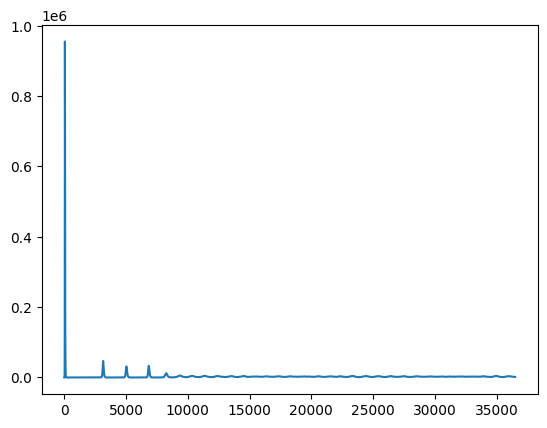

In [4]:
model = Model(scenario, parameters)
model.components = [
    Infect_Random_Agents,
    Births_ConstantPop,
    Susceptibility,
    Infection,
    Transmission,
]

seed_infections_randomly(model, ninfections=1)
model.run()
plt.plot(model.patches.cases)

### Sanity checks
As always, check that we haven't broken anything - S+I+R = N at all times

In [5]:
cases = np.squeeze(model.patches.cases)
susc = np.squeeze(model.patches.susceptibility)
rec = np.squeeze(model.patches.recovered)
inc = np.squeeze(model.patches.incidence)
births = np.squeeze(model.patches.births)
pops = np.squeeze(model.patches.populations)[:-1]

print("S+I+R = N:  " + str(np.isclose(cases + susc + rec, pops).all()))

S+I+R = N:  True


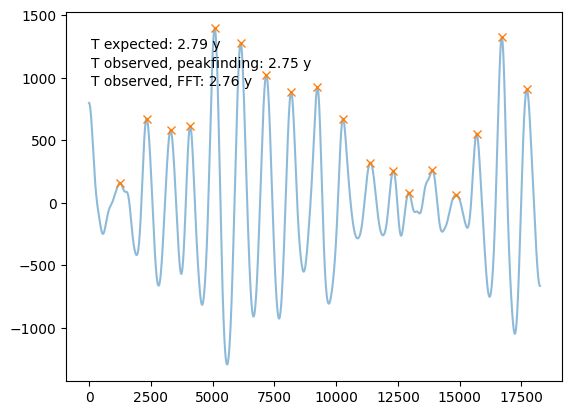

In [20]:
mu = (1 + model.params.cbr / 1000) ** (1 / 365) - 1
R0 = model.params.beta / (1 / model.params.inf_mean + mu)
A = 1 / ((R0 - 1) * mu) / 365 
G = 1 / (mu + 1 / model.params.inf_mean) / 365
T_exp = 2*np.pi *np.sqrt(A*G)

def ID_freq_peakfinder(model, T_exp, cutoff=18250, plot=False):
    y0 = np.squeeze(model.patches.cases)
    y = y0[cutoff:]
    y = y - np.mean(y)
    y = gaussian_filter1d(y, sigma=100)
    peaks, _ = find_peaks(y, distance=T_exp * 365 / 2)
    plt.figure()
    plt.plot(y, alpha=0.5)
    plt.plot(peaks, y[peaks], "x")
    return np.median(np.diff(peaks)) / 365

T_obs_pf = ID_freq_peakfinder(model, T_exp, plot=True)

def ID_freq_autocorr(model, cutoff=18250):
    y0 = np.squeeze(model.patches.cases)
    #Compute the FFT
    Y1 = np.fft.fft(y0[cutoff:] - np.mean(y0[cutoff:]))

    # Compute the circular autocorrelation using the inverse FFT
    circular_autocorr = np.fft.ifft(Y1 * np.conj(Y1)).real
    # Plot only the positive frequency spectrum
    peaks, _ = find_peaks(circular_autocorr, distance=300)
    return peaks[0] / 365

T_obs_fft = ID_freq_autocorr(model)

plt.text(0.05, 0.9, f'T expected: {T_exp:.2f} y', transform=plt.gca().transAxes)
plt.text(0.05, 0.85, f'T observed, peakfinding: {T_obs_pf:.2f} y', transform=plt.gca().transAxes)
plt.text(0.05, 0.8, f'T observed, FFT: {T_obs_fft:.2f} y', transform=plt.gca().transAxes)
plt.show()

### Larger test suite
OK, so now we are going to replicate the above test for many values of R0 and cbr, as a scientific validity test.

TODO: As written, this takes a long time.  That's because the space of random values being sampled occasionally produces models with long equilibration times and long periodicities.  So as of right now, these run for 100 years to sidestep this.  Should instead restrict the range of values - higher cbrs and R0s - so that the average age at infection is consistently lower and we can get away with running for like 30-50 years instead.  

2025-01-10 10:55:37.322951: Creating the generic model…
Initializing the generic model with 1 patches…
2025-01-10 10:55:37.368058: Running the generic model for 36500 ticks…


100%|██████████| 36500/36500 [03:28<00:00, 174.71it/s]

Completed the generic model at 2025-01-10 10:59:06.328509…
Model               :       200,040 µs
Births_ConstantPop  :     7,706,302 µs
Susceptibility      :     3,124,139 µs
Transmission        :    67,829,556 µs
Infection           :   128,372,744 µs
Infect_Random_Agents:       103,362 µs
Total:                  207,336,143 microseconds
2025-01-10 10:59:06.382840: Creating the generic model…
Initializing the generic model with 1 patches…
2025-01-10 10:59:06.415384: Running the generic model for 36500 ticks…



100%|██████████| 36500/36500 [03:26<00:00, 176.66it/s]

Completed the generic model at 2025-01-10 11:02:33.025294…
Model               :       195,110 µs
Births_ConstantPop  :     7,313,234 µs
Susceptibility      :     3,120,123 µs
Transmission        :    67,749,277 µs
Infection           :   126,639,785 µs
Infect_Random_Agents:       102,952 µs
Total:                  205,120,481 microseconds
2025-01-10 11:02:33.057105: Creating the generic model…
Initializing the generic model with 1 patches…


2025-01-10 11:02:33.087399: Running the generic model for 36500 ticks…


100%|██████████| 36500/36500 [03:25<00:00, 177.72it/s]

Completed the generic model at 2025-01-10 11:05:58.472383…
Model               :       183,993 µs
Births_ConstantPop  :     7,797,631 µs
Susceptibility      :     3,060,520 µs
Transmission        :    66,328,359 µs
Infection           :   126,390,708 µs
Infect_Random_Agents:        98,736 µs
Total:                  203,859,947 microseconds
2025-01-10 11:05:58.504119: Creating the generic model…
Initializing the generic model with 1 patches…
2025-01-10 11:05:58.534047: Running the generic model for 36500 ticks…



100%|██████████| 36500/36500 [03:30<00:00, 173.38it/s]

Completed the generic model at 2025-01-10 11:09:29.054324…
Model               :       184,667 µs
Births_ConstantPop  :     7,542,774 µs
Susceptibility      :     3,118,835 µs
Transmission        :    69,929,203 µs
Infection           :   128,081,045 µs
Infect_Random_Agents:        96,263 µs
Total:                  208,952,787 microseconds
2025-01-10 11:09:29.087398: Creating the generic model…
Initializing the generic model with 1 patches…


2025-01-10 11:09:29.116499: Running the generic model for 36500 ticks…


100%|██████████| 36500/36500 [03:42<00:00, 163.87it/s]

Completed the generic model at 2025-01-10 11:13:11.854428…
Model               :       190,483 µs
Births_ConstantPop  :     8,631,318 µs
Susceptibility      :     3,107,865 µs
Transmission        :    78,237,120 µs
Infection           :   130,751,902 µs
Infect_Random_Agents:        96,063 µs
Total:                  221,014,751 microseconds
2025-01-10 11:13:11.885649: Creating the generic model…
Initializing the generic model with 1 patches…
2025-01-10 11:13:11.914865: Running the generic model for 36500 ticks…



100%|██████████| 36500/36500 [03:58<00:00, 153.29it/s]

Completed the generic model at 2025-01-10 11:17:10.029445…
Model               :       185,267 µs
Births_ConstantPop  :     8,574,472 µs
Susceptibility      :     3,088,845 µs
Transmission        :    95,125,694 µs
Infection           :   129,399,145 µs
Infect_Random_Agents:        93,639 µs
Total:                  236,467,062 microseconds
2025-01-10 11:17:10.059512: Creating the generic model…
Initializing the generic model with 1 patches…


2025-01-10 11:17:10.089742: Running the generic model for 36500 ticks…


100%|██████████| 36500/36500 [03:34<00:00, 169.98it/s]

Completed the generic model at 2025-01-10 11:20:44.821444…
Model               :       174,033 µs
Births_ConstantPop  :     7,758,768 µs
Susceptibility      :     3,047,067 µs
Transmission        :    75,233,857 µs
Infection           :   127,002,755 µs
Infect_Random_Agents:        88,246 µs
Total:                  213,304,726 microseconds
2025-01-10 11:20:44.851415: Creating the generic model…
Initializing the generic model with 1 patches…


2025-01-10 11:20:44.879892: Running the generic model for 36500 ticks…


100%|██████████| 36500/36500 [03:23<00:00, 179.66it/s]

Completed the generic model at 2025-01-10 11:24:08.047348…
Model               :       183,310 µs
Births_ConstantPop  :     5,769,575 µs
Susceptibility      :     3,029,896 µs
Transmission        :    68,399,143 µs
Infection           :   124,199,420 µs
Infect_Random_Agents:        97,346 µs
Total:                  201,678,690 microseconds
2025-01-10 11:24:08.082128: Creating the generic model…
Initializing the generic model with 1 patches…


2025-01-10 11:24:08.139864: Running the generic model for 36500 ticks…


100%|██████████| 36500/36500 [03:32<00:00, 171.63it/s]

Completed the generic model at 2025-01-10 11:27:40.810938…
Model               :       187,040 µs
Births_ConstantPop  :     9,496,616 µs
Susceptibility      :     3,079,316 µs
Transmission        :    69,430,395 µs
Infection           :   128,900,403 µs
Infect_Random_Agents:        99,429 µs
Total:                  211,193,199 microseconds
2025-01-10 11:27:40.841269: Creating the generic model…
Initializing the generic model with 1 patches…
2025-01-10 11:27:40.872031: Running the generic model for 36500 ticks…



100%|██████████| 36500/36500 [03:44<00:00, 162.94it/s]


Completed the generic model at 2025-01-10 11:31:24.885174…
Model               :       189,717 µs
Births_ConstantPop  :     8,845,649 µs
Susceptibility      :     3,080,818 µs
Transmission        :    81,379,889 µs
Infection           :   128,893,687 µs
Infect_Random_Agents:        98,426 µs
Total:                  222,488,186 microseconds


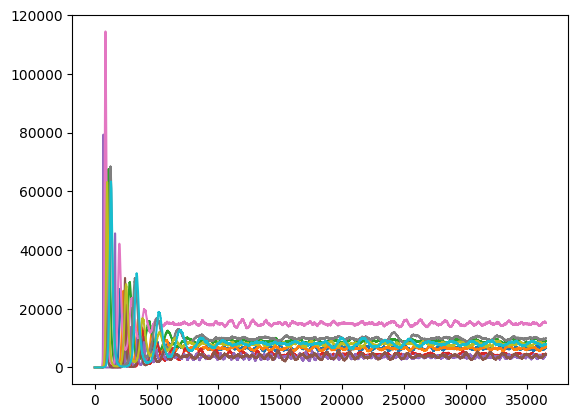

In [ ]:
#import os

nsims = 10
nticks = 36500
cbrs = 15 + 85 * np.random.rand(nsims)
inf_means = 5 + 45 * np.random.rand(nsims)
R0s = 1.5 + 8.5 * np.random.rand(nsims)
mu = [((1 + cbr / 1000) ** (1 / 365) - 1) for cbr in cbrs]
A = [1 / ((R0 - 1) * mu) / 365 for R0, mu in zip(R0s, mu)]
G = [1 / (mu + 1 / inf_mean) / 365 for mu, inf_mean in zip(mu, inf_means)]
T_exp = [2 * math.pi * np.sqrt(A * G) for A, G in zip(A, G)]
mycases = np.zeros((nsims, nticks))
params_df = pd.DataFrame(
    {
        "cbr": cbrs,
        "inf_mean": inf_means,
        "R0": R0s,
        "A": A,
        "G": G,
        "T_exp": T_exp,
    }
)
i = 0
for cbr, inf_mean, R0 in zip(cbrs, inf_means, R0s):
    mu = (1 + cbr / 1000) ** (1 / 365) - 1
    parameters = PropertySet(
        {
            "seed": 2,
            "nticks": 36500,
            "verbose": True,
            "beta": R0 * (mu + 1 / inf_mean),
            "inf_mean": inf_mean,
            "cbr": cbr,
            "importation_period": 180,
            "importation_count": 3,
        }
    )
    model = Model(scenario, parameters)
    model.components = [
        Births_ConstantPop,
        Susceptibility,
        Transmission,
        Infection,
        Infect_Random_Agents,
    ]

    set_initial_susceptibility_randomly(model, 1 / R0 + 0.02)
    seed_infections_randomly(model, ninfections=1)
    model.run()
    plt.plot(model.patches.cases)
    mycases[i] = np.squeeze(model.patches.cases)
    i = i + 1

#output_folder = os.path.abspath(os.path.join(os.getcwd(), "..", "..", "laser-generic-outputs", "periodicity"))
#os.makedirs(output_folder, exist_ok=True)
#params_df.to_csv(os.path.join(output_folder, "params_df.csv"), index=False)
#np.save(os.path.join(output_folder, "mycases.npy"), mycases)

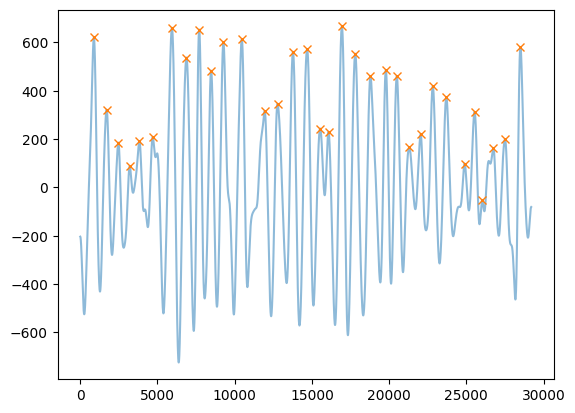

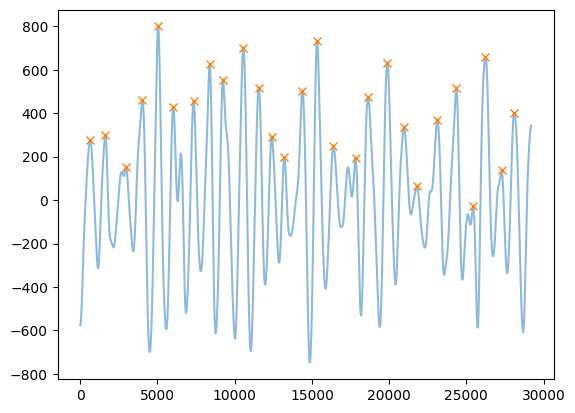

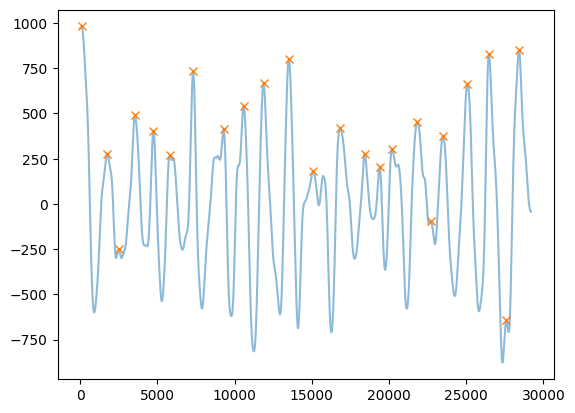

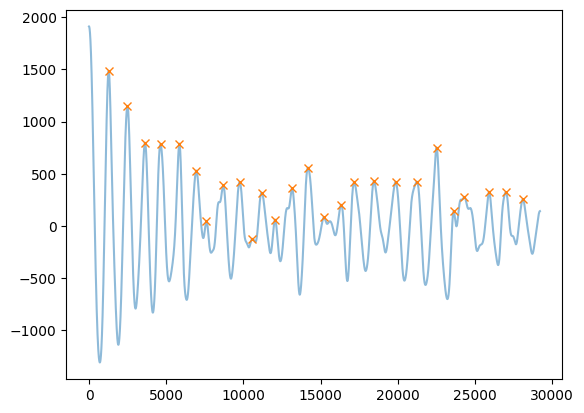

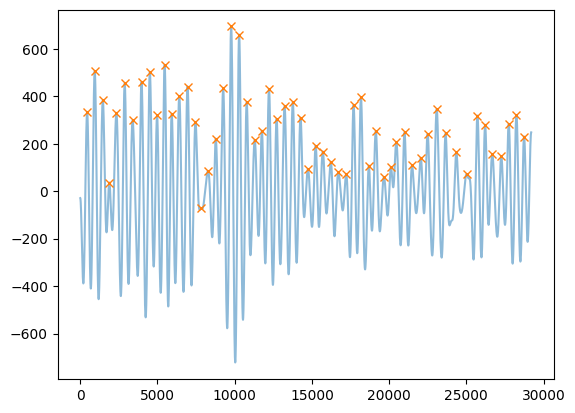

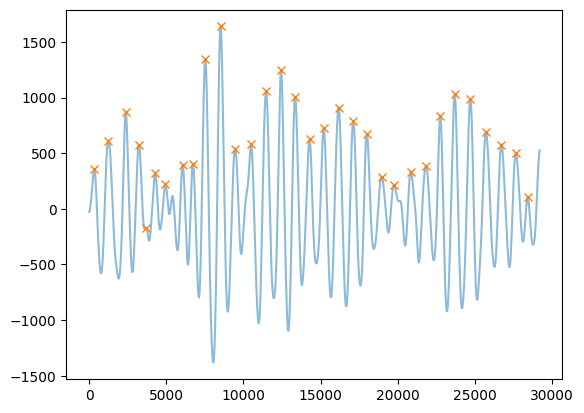

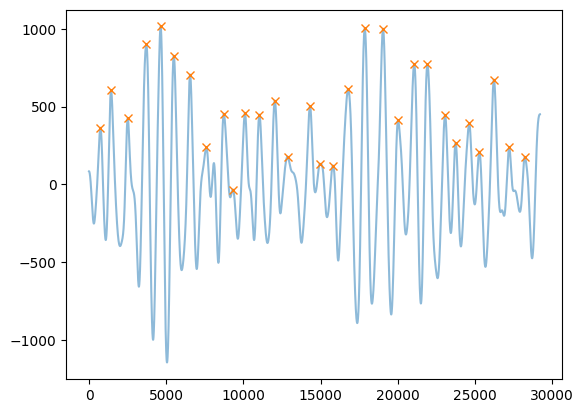

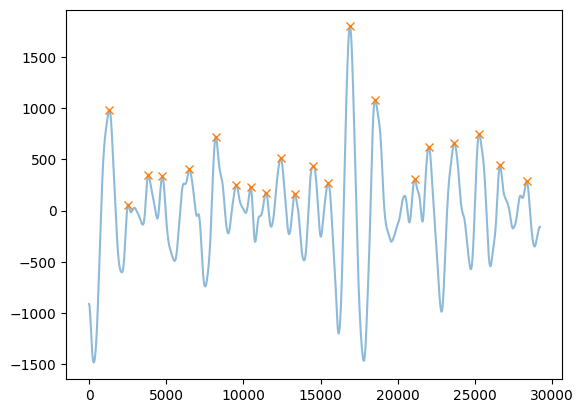

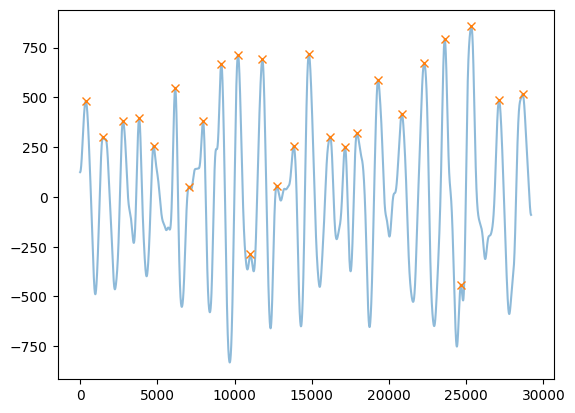

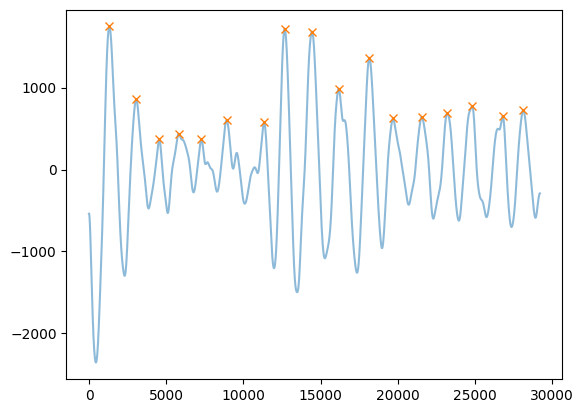

In [ ]:
params_df["T_obs_peakfinder"] = np.nan
params_df["T_obs_autocorr"] = np.nan

for i in range(10):
    y0 = np.squeeze(mycases[i, :])
    y = y0[7300:]
    y = y - np.mean(y)
    y = gaussian_filter1d(y, sigma=100)
    peaks, _ = find_peaks(y, distance=params_df.loc[i, "T_exp"] * 365 / 2)
    plt.figure()
    plt.plot(y, alpha=0.5)
    plt.plot(peaks, y[peaks], "x")
    params_df.loc[i, "T_obs_peakfinder"] = np.median(np.diff(peaks)) / 365

    # Compute the FFT of the zero-padded signal
    Y1 = np.fft.fft(y0[7300:] - np.mean(y0[7300:]))

    # Compute the circular autocorrelation using the inverse FFT
    circular_autocorr = np.fft.ifft(Y1 * np.conj(Y1)).real
    # Plot only the positive frequency spectrum
    peaks, _ = find_peaks(circular_autocorr, distance=300)
    params_df.loc[i, "T_obs_autocorr"] = peaks[0] / 365

In [6]:
params_df["mu"] = (1 + params_df["cbr"] / 1000) ** (1 / 365) - 1

params_df["A"] = 1 / ((params_df["R0"] - 1) * params_df["mu"]) / 365
params_df["T_exp"] = 2 * np.pi * np.sqrt(params_df["A"] * params_df["G"])

Bad pipe message: %s [b'\xcew\x1c\x80\xbd\x82\x1aq\xcb\x9b,l\xc4\xce\xd5\xdar\xfc\x00\x01|\x00\x00\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07\x00\x08\x00\t\x00\n\x00\x0b\x00\x0c\x00\r\x00\x0e\x00\x0f\x00\x10\x00\x11\x00\x12\x00\x13\x00\x14\x00\x15\x00\x16\x00\x17\x00\x18\x00\x19\x00\x1a\x00\x1b\x00/\x000\x001\x002\x00', b'4\x005\x006\x007\x008\x009\x00:\x00;\x00<\x00=\x00>\x00?\x00@\x00A\x00B\x00C\x00D\x00E\x00F\x00g\x00h\x00i\x00j\x00k\x00l\x00']
Bad pipe message: %s [b'\x84\x00\x85\x00\x86\x00\x87\x00\x88\x00\x89\x00\x96\x00\x97\x00\x98\x00\x99\x00\x9a\x00\x9b\x00\x9c\x00\x9d\x00\x9e\x00\x9f\x00\xa0\x00\xa1\x00\xa2\x00\xa3\x00\xa4\x00\xa5\x00\xa6\x00\xa7\x00\xba\x00\xbb\x00\xbc\x00\xbd\x00\xbe\x00\xbf\x00\xc0\x00\xc1\x00\xc2\x00\xc3\x00\xc4\x00\xc5\x13\x01\x13\x02\x13\x03\x13\x04\x13\x05\xc0\x01\xc0\x02\xc0\x03\xc0\x04\xc0\x05\xc0\x06\xc0\x07\xc0\x08\xc0\t\xc0\n\xc0\x0b\xc0\x0c\xc0\r\xc0']
Bad pipe message: %s [b'\x0f\xc0\x10\xc0\x11\xc0\x12\xc0\x13\xc0\x14\xc0\x15']
Bad

In [27]:
params_df

,cbr,inf_mean,R0,A,G,T_exp,T_obs_peakfinder,T_obs_autocorr,mu
0,91.389442,28.841175,8.144232,1.600386,0.078475,2.226674,2.089041,2.169863,0.000240
1,72.427974,43.599935,1.947351,15.094319,0.118462,8.401885,8.506849,8.249315,0.000192
2,99.292046,7.388431,4.257358,3.242518,0.020204,1.608181,1.695890,1.723288,0.000259
3,54.373102,10.087311,5.493067,4.203290,0.027596,2.139924,2.258904,2.312329,0.000145
4,24.316669,24.917049,2.465888,28.392804,0.068154,8.740374,7.669863,9.580822,0.000066
5,25.335873,11.273769,6.950007,6.717012,0.030863,2.860805,3.046575,3.123288,0.000069
6,78.450087,49.493410,6.040825,2.626415,0.134224,3.730577,3.158904,3.654795,0.000207
7,64.193555,13.921366,8.527873,2.134910,0.038050,1.790810,1.801370,1.797260,0.000170
8,33.428807,32.883485,5.259423,7.139514,0.089826,5.031695,4.997260,5.164384,0.000090
9,61.545651,24.964564,4.007677,5.566341,0.068118,3.868967,3.876712,3.876712,0.000164


Bad pipe message: %s [b'*`"2@s\xa6\x1a\xd5\x17\x80\xd6sR\'\x15\x99\x9b\x00\x01|\x00\x00\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07\x00\x08\x00\t\x00\n\x00\x0b\x00\x0c\x00\r\x00\x0e\x00\x0f\x00\x10\x00\x11\x00\x12\x00\x13\x00\x14\x00\x15\x00\x16\x00\x17\x00\x18\x00\x19\x00\x1a\x00\x1b\x00/\x000\x001\x002\x003\x004\x005\x006\x007\x008\x009\x00:\x00;\x00<\x00=\x00>\x00?\x00@\x00A\x00B\x00C\x00D\x00E\x00F\x00g\x00h\x00i\x00j\x00k\x00l\x00m\x00\x84\x00\x85\x00\x86\x00\x87']
Bad pipe message: %s [b'\xcej\xed\xf7\xa9g(\x87\xc6\xe4o\xb3\xb4\xe7\tp\x0b\x1b\x00\x01|\x00\x00\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07\x00\x08\x00\t\x00\n\x00\x0b\x00\x0c\x00\r\x00\x0e\x00\x0f\x00\x10\x00\x11\x00\x12\x00\x13\x00\x14\x00\x15\x00\x16\x00\x17\x00\x18\x00\x19\x00\x1a\x00\x1b\x00/\x000\x001\x002\x003\x004\x005\x006\x007\x008\x009\x00:\x00;\x00<\x00=\x00>\x00?\x00@\x00A\x00B\x00C\x00D\x00E\x00F\x00g\x00h\x00i\x00j\x00k\x00l\x00m\x00\x84\x00\x85\x00\x86\x00\x87\x00\x88\x00\x89\x00

In [1]:
plt.plot(params_df["T_exp"], params_df["T_obs_peakfinder"], "o")

NameError: name 'plt' is not defined

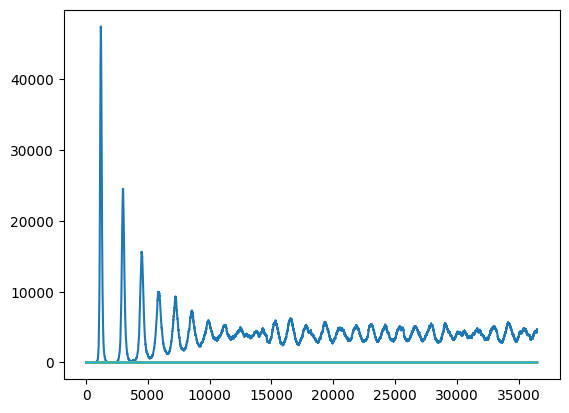